In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
%matplotlib inline

# 1.加载小汽车图片集，并随机选64张展示出来


In [2]:
car_images = glob.glob('training_dataset/vehicles/**/**/*.png')
noncar_images = glob.glob('training_dataset/non-vehicles/**/**/*.png')
print(len(car_images),len(noncar_images))

8792 8968


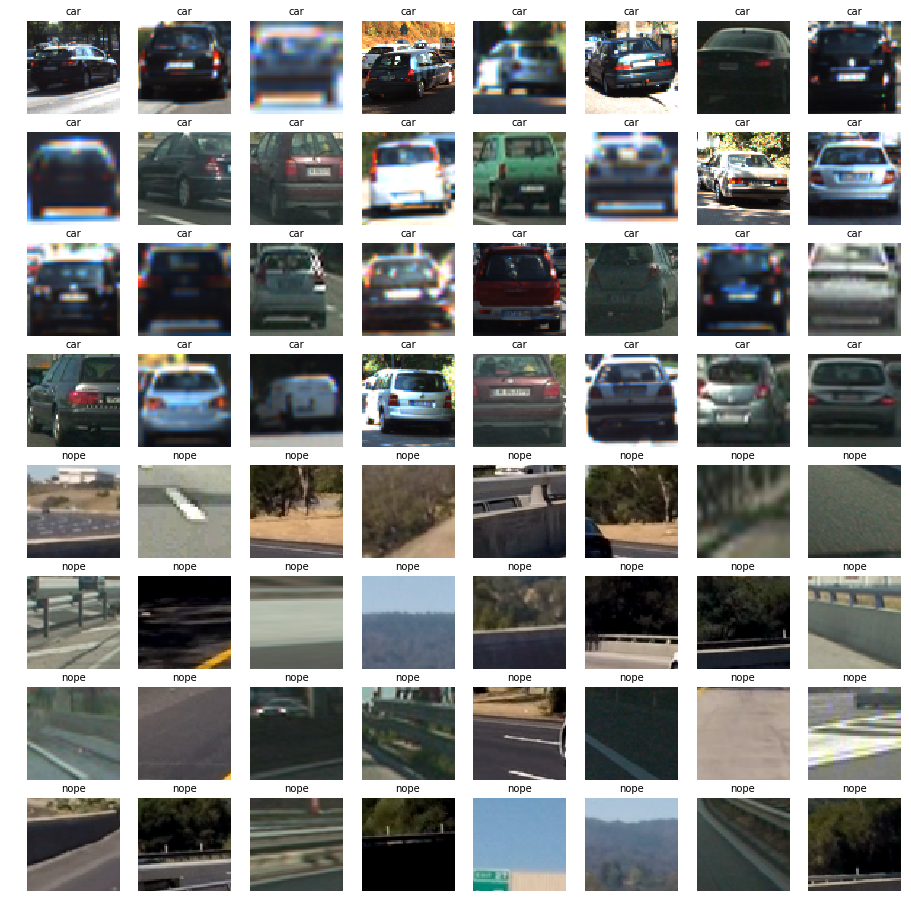

In [3]:
fig,axs = plt.subplots(8,8,figsize = (16,16))
fig.subplots_adjust(hspace = .2, wspace = .001)
axs = axs.ravel()
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car',fontsize = 10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope',fontsize = 10)
    axs[i].imshow(img)

# 2.完成get_hog_features函数
输入图片img、orient数量、cell大小、block大小、是否可视化vis、是否一维feature_vec
  输出：两种情况  features 和 hog_image。    
  使用：输入两张图片，验证效果。

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis = False, feature_vec = True):
    if vis == True:
        features,hog_image = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell,pix_per_cell),
                                 cells_per_block = (cell_per_block,cell_per_block),
                                 transform_sqrt=False,
                                 visualise = vis,feature_vector = feature_vec)
        return features,hog_image
    else:
        features = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell,pix_per_cell),
                                 cells_per_block = (cell_per_block,cell_per_block),
                                 transform_sqrt=False,
                                 visualise = vis,feature_vector = feature_vec)
        return features
print('...')

...


...


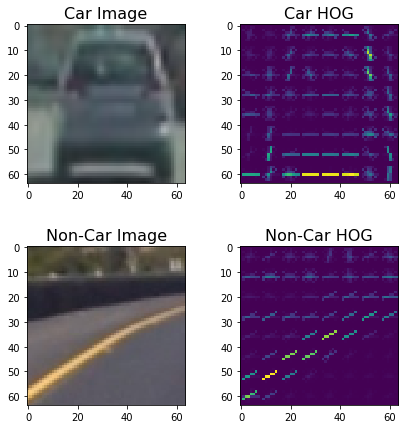

In [21]:
car_img = mpimg.imread(car_images[5])
car_hist,car_dst = get_hog_features(car_img[:,:,2],orient=9,pix_per_cell=8,cell_per_block=8,vis = True,feature_vec=False)
noncar_img = mpimg.imread(noncar_images[5])
noncar_hist,noncar_dst = get_hog_features(noncar_img,orient=9,pix_per_cell=8,cell_per_block=8,vis=True,feature_vec=False)

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize = (7,7))
fig.subplots_adjust(hspace = .4, wspace = .2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize = 16)
ax2.imshow(car_dst)
ax2.set_title('Car HOG', fontsize = 16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image',fontsize = 16)
ax4.imshow(noncar_dst)
ax4.set_title('Non-Car HOG', fontsize = 16)
print('...')

In [22]:
print(car_img.shape,car_dst.shape,car_hist.shape)


(64, 64, 3) (64, 64) (1, 1, 8, 8, 9)


注意看car_hist 的shape：1,1,8,8,9 重点是8,8,9

# 3.完成extract_features函数。
输入(imgs, cspace, orient, pix_per_cell, cell_per_block, hog_channel)
   输出：features = 相关层的hog结果。  功能：将图片集中所有的图片都变成features
   使用：将图片集中所有的图片都变成features存在变量X中，label存在y中，shuffle。对比选择不同参数时的提取时间

In [6]:
def extract_features(imgs, cspace='RGB', orient = 9, pix_per_cell=8, cell_per_block=2, hog_channel= 0):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image,cv2.COLORRGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image =cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],orient,pix_per_cell,cell_per_block,vis = False,feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],orient,pix_per_cell,cell_per_block,
                                       vis = False, feature_vec=True)
        features.append(hog_features)
    return features
print('...')

...


In [7]:
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
t = time.time()
car_features = extract_features(car_images, cspace=colorspace,orient=orient,
                                pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
noncar_features = extract_features(noncar_images,cspace=colorspace,orient=orient,
                                  pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                  hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t,2),' Seconds to extract HOG features...')


54.02  Seconds to extract HOG features...


In [8]:
X = np.vstack((car_features,noncar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)),np.zeros(len(noncar_features))))

rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.2,random_state = rand_state)
print('Using:',orient,'orientations ',pix_per_cell,'pixel per cell and',
     cell_per_block,'cell per block')
print('Feature vector length:',len(X_train[0]))

Using: 11 orientations  16 pixel per cell and 2 cell per block
Feature vector length: 1188


In [26]:
print(X.shape)

(17760, 1188)


# 4.训练一个classifier
LinearSVC。并验证其预测准确率。对比不同参数下的准确率训练时间。输入的图片只是一个slide window里面的图像

In [9]:
svc = LinearSVC()
t = time.time()
svc.fit(X_train,y_train)
t2 = time.time()
print(round(t2-t,2),' Seconds to train SVC...')
print('Test Accuracy of SVC = ',round(svc.score(X_test,y_test),4))
t = time.time()
n_predict = 10
print('My SVC predicts:',svc.predict(X_test[:n_predict]))
print('For these ',n_predict,' labels:',y_test[:n_predict])
t2 = time.time()
print(round(t2-t,5),'Seconds to predict',n_predict,'labels with SVC')

4.31  Seconds to train SVC...
Test Accuracy of SVC =  0.9817
My SVC predicts: [0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
For these  10  labels: [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
0.03803 Seconds to predict 10 labels with SVC


# 5.完成find_cars函数
该函数使用上文classifier来搜索汽车。           
   输入（img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles）。此处输入img为相机原始图像         
   输出rectangles一个list用来存放汽车左上角和右下角的像素坐标。           
   过程包含ROI-->颜色空间转换-->图片的缩放-->以block为单位确定x,y方向的steps-->根据hog_channel得到整幅图hog_features-->for循环里每一个block得到小的hog_features,并用svc预测-->找到汽车后，按原图的比例反向缩放-->左上角右下角存在rectangle       
   使用：读取一张test_img输入进find_cars函数，将find结果展示出来    

In [29]:
def find_cars(img,ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient,
             pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles = False):
    rectangles = []
    img = img.astype(np.float32)/255
    image_tosearch = img[ystart:ystop,:,:]
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(image_tosearch,cv2.COLOR_RGB2HSV)
        if cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(image_tosearch,cv2.COLOR_RGB2LUV)
        if cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(image_tosearch,cv2.COLOR_RGB2HLS)
        if cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(image_tosearch,cv2.COLOR_RGB2YUV)
        if cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(image_tosearch,cv2.COLOR_RGB2YCrCb)
    else:
        ctrans_tosearch = np.copy(image_tosearch)
    
    if scale!= 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,(np.int(imshape[1]/scale),np.int(imshape[0]/scale)))
        
    nx_cells = ctrans_tosearch.shape[1]//pix_per_cell + 1
    ny_cells = ctrans_tosearch.shape[0]//pix_per_cell + 1
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    ncells_per_window = (window//pix_per_cell) - 1
    cells_per_step = 2
    nx_steps = (nx_cells - ncells_per_window)//cells_per_step
    ny_steps = (ny_cells - ncells_per_window)//cells_per_step
    
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]
    
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,feature_vec=False)
        hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,feature_vec=False)
    
    
    for xb in range(nx_steps):
        for yb in range(ny_steps):
            xpos = xb * cells_per_step
            ypos = yb * cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            hog_feat1 = hog1[ypos:ypos+ncells_per_window,xpos:xpos+ncells_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+ncells_per_window,xpos:xpos+ncells_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+ncells_per_window,xpos:xpos+ncells_per_window].ravel()
                hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            else:
                hog_features = hog_feat1
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window * scale)
                rectangles.append(((xbox_left,ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart)))
    return rectangles

print('...')            

...


In [30]:
test_img = mpimg.imread('test_images/test1.jpg')
ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None)
print(len(rectangles),'rectangles found in the image')

6 rectangles found in the image


# 6.完成draw_boxes函数
用来将boxes绘制在图片中

In [31]:
def draw_boxes(img,bboxes,color = (0,0,255),thick = 6):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy,bbox[0],bbox[1],color,thick)
    return imcopy
print('...')


...


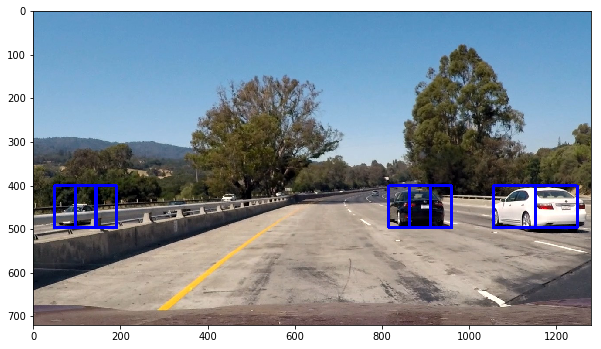

In [32]:
test_img_rect = draw_boxes(test_img,rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rect)

# 7.完成add_heat函数
输入(heatmap, bbox_list)输出heatmap

In [33]:
def add_heat(heatmap,bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
    return heatmap

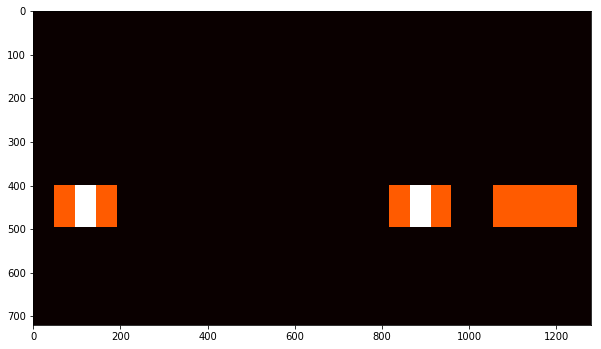

In [34]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img,rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img,cmap = 'hot')

#  8.完成apply_threshold函数
输入(heatmap,threshold)输出heatmap

In [35]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap<= threshold]=0
    return heatmap

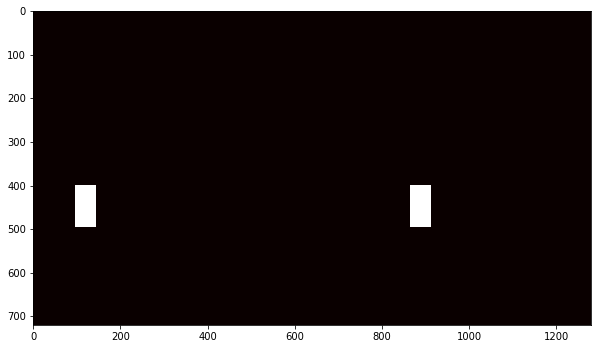

In [36]:
heatmap_img = apply_threshold(heatmap_img,1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img,cmap = 'hot')

# 9. 完成draw_labeled_bboxes函数
输入(img, labels)输出img和rect

2 cars found


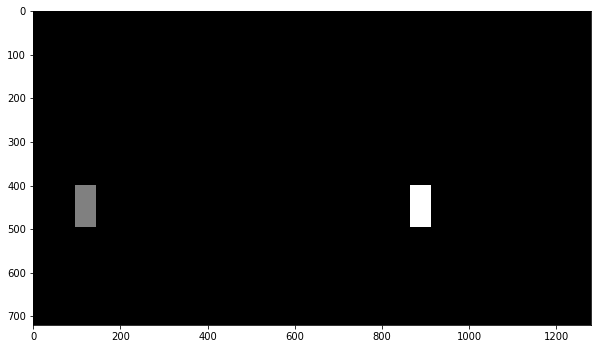

In [38]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0],cmap = 'gray')
print(labels[1],'cars found')

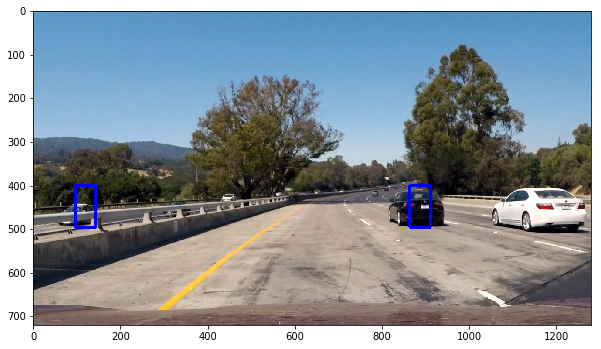

In [39]:
def draw_labeled_bboxes(img, labels):
    rects = []
    for car_number in range(1,labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        rects.append(bbox)
        cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)
    return img,rects

draw_img,rect = draw_labeled_bboxes(np.copy(test_img),labels)
plt.figure(figsize = (10,10))
plt.imshow(draw_img)

# 10. 完成process_frame函数
输入img,输出：draw_img
过程包括：从1）---9）外加labels = label(heatmap_img)
使用：在6张test image中进行测试。在test_video中进行测试

In [40]:
def process_frame(img):
    rectangles =[]
    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient,pix_per_cell,cell_per_block,None,None))
    
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient,pix_per_cell,cell_per_block,None,None))
    
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient,pix_per_cell,cell_per_block,None,None))
    
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient,pix_per_cell,cell_per_block,None,None))
    
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient,pix_per_cell,cell_per_block,None,None))
    
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient,pix_per_cell,cell_per_block,None,None))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient,pix_per_cell,cell_per_block,None,None))
    
    rectangles = [item for sublist in rectangles for item in sublist]
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img,rectangles)
    heatmap_img = apply_threshold(heatmap_img,1)
    labels = label(heatmap_img)
    draw_img,rects = draw_labeled_bboxes(np.copy(img),labels)
    return draw_img

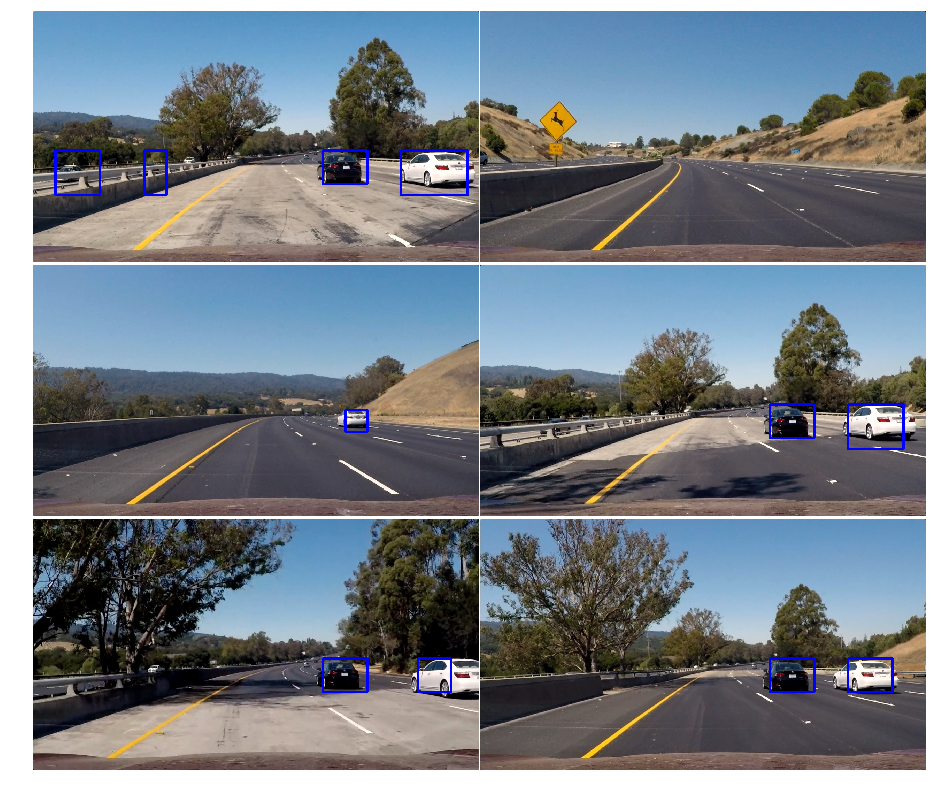

In [42]:
test_images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(3,2,figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace = .002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

# 11. 写一个Vehicle_Detect类来存储检测到的汽车数据

In [43]:
class Vehicle_Detect():
    def __init__(self):
        self.prev_rects = []
        
    def add_rects(self,rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects)>15:
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('...')

...


# 12. 完成process_frame_for_video函数
输入img,输出draw_img.与process-frame函数基本一致.       
    使用，对一个video进行测试。

In [49]:
def process_frame_for_video(img):
    rectangles = []
    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient, pix_per_cell, cell_per_block,None,None))
    
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient, pix_per_cell, cell_per_block,None,None))
    
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient, pix_per_cell, cell_per_block,None,None))
    
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient, pix_per_cell, cell_per_block,None,None))
    
    ystart = 400
    ystop = 428
    scale = 2.0
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient, pix_per_cell, cell_per_block,None,None))
    
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient, pix_per_cell, cell_per_block,None,None))
    
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient, pix_per_cell, cell_per_block,None,None))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,
                               orient, pix_per_cell, cell_per_block,None,None))
    
    rectangles = [item for sublist in rectangles for item in sublist]
    
    if len(rectangles)>0:
        det.add_rects(rectangles)
        
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img),labels)
    return draw_img

In [47]:
def nochange(img):
    return img


In [51]:
det = Vehicle_Detect()
test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame)#nochange
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

Moviepy - Building video test_video_out_2.mp4.
Moviepy - Writing video test_video_out_2.mp4



Moviepy - Done !
Moviepy - video ready test_video_out_2.mp4
Wall time: 15.7 s
